In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, ALL_TIMES,interpline, CoordPair, xy_to_ll, ll_to_xy)
import pandas as pd
import numpy as np
import os
import shutil
import re
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker
import cartopy.crs as ccrs                                               
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import shapefile
import geopandas as gpd
from matplotlib.backends.backend_pdf import PdfPages

# landuse

In [2]:
ds_lu = xr.open_dataset('/home/dataop/data/nmodel/cmip6-wrf-arch/hist_2010s/2011/analysis/wrfout_d04_2011-06-23_11:00:00')
lu = ds_lu['LU_INDEX']

lu = lu[0,:,:]

del lu.coords['XTIME']

In [3]:
lu_df = lu.to_dataframe().reset_index()

# correction value

In [4]:
ds_era5_1120 = xr.open_dataset('bias_era5_cmip6_1120.nc')
cv_era5_1120 = ds_era5_1120['bias_era5_cmip6_1120']

In [5]:
cv_era5_monthmean_1120 = cv_era5_1120.mean(dim='month')

cv_era5_mean_1120 = cv_era5_monthmean_1120.mean(dim='hour')

In [6]:
cv_era5_mean_1120_df = cv_era5_mean_1120.to_dataframe().reset_index()

In [7]:
print((cv_era5_mean_1120_df['south_north']-lu_df['south_north']).min())
print((cv_era5_mean_1120_df['south_north']-lu_df['south_north']).max())
print((cv_era5_mean_1120_df['south_north']-lu_df['south_north']).mean())
print((cv_era5_mean_1120_df['west_east']-lu_df['west_east']).min())
print((cv_era5_mean_1120_df['west_east']-lu_df['west_east']).max())
print((cv_era5_mean_1120_df['west_east']-lu_df['west_east']).mean())

0
0
0.0
0
0
0.0


In [8]:
#filter land grid cells for plotting use
cv_era5_mean_1120_df['lu'] = lu_df['LU_INDEX']
cv_era5_mean_1120_df.loc[cv_era5_mean_1120_df.lu == 16, 'bias_era5_cmip6_1120'] = np.nan

In [9]:
#convert back to ncfile
cv_era5_mean_1120_df.sort_values(['south_north','west_east'],ascending=[True,True],inplace=True)

cv_era5_mean_1120_values = cv_era5_mean_1120_df.bias_era5_cmip6_1120.values 
cv_era5_mean_1120_values = cv_era5_mean_1120_values.reshape(162,213)

XLAT = lu.XLAT
XLONG = lu.XLONG
south_north = lu.south_north
west_east = lu.west_east

cv_era5_mean_1120_xr = xr.DataArray(cv_era5_mean_1120_values,
                             dims=["south_north","west_east"],
                             coords=dict(
                             XLONG=(["south_north", "west_east"], XLONG),
                             XLAT=(["south_north", "west_east"], XLAT),
                             lu = lu))

ds_cv_era5_mean_1120 = xr.Dataset({'cv_era5_mean_1120': cv_era5_mean_1120_xr})

# plot

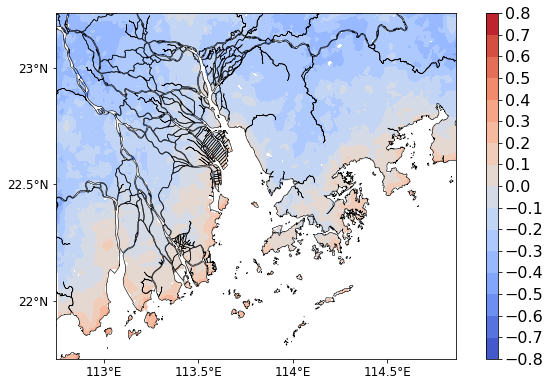

In [14]:
PRD = gpd.read_file('/home/zzuoaa/evaluation_CMIP6/May/fine_coastline/china_coastline.shp')

plt.rcParams["font.family"] = "DejaVu Sans"
font={'weight':'medium',
      'color':'black',
      'size':12}

fig,ax1 = plt.subplots(ncols=1,figsize=(8,8))

ax1 = PRD.geometry.plot(ax=ax1,edgecolor='black',facecolor='none',linewidth=0.6,linestyle='solid')

C11 = ax1.contourf(ds_cv_era5_mean_1120.XLONG,ds_cv_era5_mean_1120.XLAT,ds_cv_era5_mean_1120.cv_era5_mean_1120,\
                   np.arange(-0.8, 0.9, 0.1),cmap="coolwarm")

fig.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0, 
                    hspace=0)

position = fig.add_axes([0.90, 0.2, 0.02, 0.6])#位置[左,下,右,上]
cb = fig.colorbar(C11, cax=position,fraction=0.05)
cb.set_label('',fontdict=font)
cb.set_ticks(np.arange(-0.8, 0.9, 0.1))
cb.ax.tick_params(labelsize=16) 

ax1.set_xlim([112.74554443, 114.86462402])
ax1.set_ylim([21.75164032, 23.23461723])
ax1.set_xticks([113,113.5,114,114.5])
ax1.set_yticks([22,22.5,23])
ax1.set_xticklabels([113,113.5,114,114.5], fontdict=font) 
ax1.set_yticklabels([22,22.5,23], fontdict=font)
ax1.xaxis.set_major_formatter(LongitudeFormatter())#刻度格式转换为经纬度样式                       
ax1.yaxis.set_major_formatter(LatitudeFormatter())                       

plt.rcParams['savefig.dpi'] = 500 #图片像素
plt.rcParams['figure.dpi'] = 500 #分辨率

plt.show()

fig.savefig('cv_era1120.png',bbox_inches='tight',dpi=500)
